# 0200 ランダムフォレスト回帰
- 多変数が複雑に関連し合っている場合、単純な線形モデルよりも決定木モデルのほうが精度が高い場合がある。
- 特に、変数同士の非線形な関係を捉えやすい
- 交互作用の検出力高

ただし、
- モデルの複雑性が増す
- ハイパーパラメータがブラックボックス化しやすい

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from constants import *

plt.style.use('ggplot')
sns.set_palette('flare')

%load_ext autoreload
%autoreload 2

## 0. データ取得

In [2]:
raw_data = pd.read_csv(os.path.join(RAW_PATH, 'train.csv'), index_col=0)
raw_data.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


### RFR用にデータを整形
順序・名義尺度はダミー変数化するため、基本的な特徴量のみ作成

In [9]:
all_data = raw_data.copy()

all_data['log_price'] = np.log(all_data['SalePrice'])

all_data['total_sf'] = all_data['1stFlrSF'] + all_data['2ndFlrSF'].fillna(0) + all_data['TotalBsmtSF'].fillna(0)

all_data['has_2nd'] = (all_data['2ndFlrSF'] > 0).astype(int)

all_data['has_bsmt'] = (all_data['TotalBsmtSF'] > 0).astype(int)

all_data['has_garage'] = (all_data['GarageArea'] > 0).astype(int)

all_data['has_pool'] = (all_data['PoolArea'] > 0).astype(int)

all_data['house_age'] = all_data['YrSold'] - all_data['YearBuilt']

all_data['remod_age'] = all_data['YrSold'] - all_data['YearRemodAdd']

all_data['yrs_before_remod'] = all_data['YearRemodAdd'] - all_data['YearBuilt']

all_data['built_era'] = pd.cut(
    all_data['YearBuilt'],
    bins=[1800, 1900, 1940, 1960, 1980, 2000, 2020],
    labels=['pre_1900', '1900-1940', '40-60', '60-80', '80-2000', 'post-2000']
)

all_data['is_remodeled'] = (all_data['remod_age'] > all_data['YearBuilt']).astype(int)

all_data.drop(columns=[
    'SalePrice', '1stFlrSF', '2ndFlrSF', 'TotalBsmtSF',
    'GarageArea', 'PoolArea', 'YrSold', 'YearBuilt', 'YearRemodAdd'
    ], inplace=True)

all_data.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,total_sf,has_2nd,has_bsmt,has_garage,has_pool,house_age,remod_age,yrs_before_remod,built_era,is_remodeled
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,2566,1,1,1,0,5,5,0,post-2000,0
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,2524,0,1,1,0,31,31,0,60-80,0
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,2706,1,1,1,0,7,6,1,post-2000,0
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,2473,1,1,1,0,91,36,55,1900-1940,0
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,3343,1,1,1,0,8,8,0,80-2000,0


In [10]:
for col in all_data.columns:
    if all_data[col].dtype == 'object':
        all_data[col].fillna('None')
    if all_data[col].dtype == 'float64' or all_data[col].dtype == 'int64':
        all_data[col].fillna(0)

all_data.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,total_sf,has_2nd,has_bsmt,has_garage,has_pool,house_age,remod_age,yrs_before_remod,built_era,is_remodeled
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,2566,1,1,1,0,5,5,0,post-2000,0
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,2524,0,1,1,0,31,31,0,60-80,0
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,2706,1,1,1,0,7,6,1,post-2000,0
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,2473,1,1,1,0,91,36,55,1900-1940,0
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,3343,1,1,1,0,8,8,0,80-2000,0


In [11]:
data = pd.get_dummies(all_data, drop_first=True, dtype=int)
data.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,LowQualFinSF,...,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,built_era_1900-1940,built_era_40-60,built_era_60-80,built_era_80-2000,built_era_post-2000
Id,,,,,,,,,,,,,,,,,,,,,
1,60,65.0,8450,7,5,196.0,706,0,150,0,...,0,0,0,1,0,0,0,0,0,1
2,20,80.0,9600,6,8,0.0,978,0,284,0,...,0,0,0,1,0,0,0,1,0,0
3,60,68.0,11250,7,5,162.0,486,0,434,0,...,0,0,0,1,0,0,0,0,0,1
4,70,60.0,9550,7,5,0.0,216,0,540,0,...,0,0,0,0,0,1,0,0,0,0
5,60,84.0,14260,8,5,350.0,655,0,490,0,...,0,0,0,1,0,0,0,0,1,0


## 1. 単純なRFR実装
まずは、全ての変数を単純なランダムフォレスト回帰に入れ込んで予測してみる

In [16]:
from sklearn.model_selection import train_test_split

X = data.drop('log_price', axis=1)
y = data['log_price']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=99)

In [17]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error, r2_score

test = RandomForestRegressor()
test.fit(X_train, y_train)

y_pred = test.predict(X_val)

rmse = root_mean_squared_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

print('Test RFR')
print(f'  RMSE: {rmse}')
print(f'  R2: {r2}')

Test RFR
  RMSE: 0.11628908731288644
  R2: 0.8955554947190287


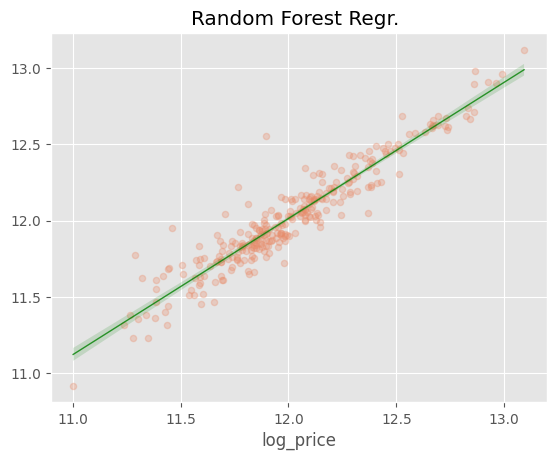

In [18]:
sns.regplot(x=y_val, y=y_pred, scatter_kws={'s': 20, 'alpha': 0.3}, line_kws={'color': 'green', 'lw': 1, 'alpha': 0.8})
plt.title(f"Random Forest Regr. ")
plt.show()

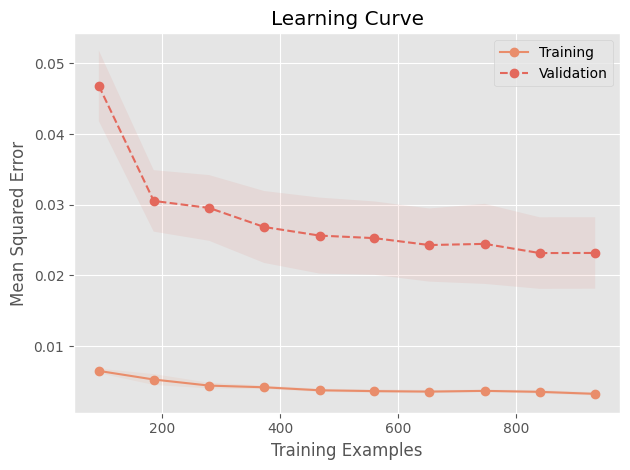

In [20]:
from utils import plot_learning_curve

plot_learning_curve(RandomForestRegressor(), X_train, y_train)
plt.show()

#### 明らかに過学習

In [39]:
import optuna

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=33)

def objective(trial):
    
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 5, 150),
        'max_depth': trial.suggest_int('max_depth', 3, 30),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features': trial.suggest_int('max_features', 1, 20)
        }
    
    rfr = RandomForestRegressor(
        **params,
        n_jobs=-1,
        random_state=87)
    
    rfr.fit(X_train, y_train)
    
    y_pred = rfr.predict(X_val)
    rmse = root_mean_squared_error(y_val, y_pred)
    
    return rmse

In [40]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=200, n_jobs=-1)

[I 2025-05-09 14:44:54,446] A new study created in memory with name: no-name-6bc4da16-932b-4b81-85de-4729e44e7e43


[I 2025-05-09 14:44:55,084] Trial 7 finished with value: 0.3008187070179581 and parameters: {'n_estimators': 36, 'max_depth': 3, 'min_samples_split': 6, 'min_samples_leaf': 3, 'max_features': 3}. Best is trial 7 with value: 0.3008187070179581.
[I 2025-05-09 14:44:55,091] Trial 5 finished with value: 0.16496224350979977 and parameters: {'n_estimators': 47, 'max_depth': 9, 'min_samples_split': 6, 'min_samples_leaf': 9, 'max_features': 19}. Best is trial 5 with value: 0.16496224350979977.
[I 2025-05-09 14:44:55,112] Trial 3 finished with value: 0.34857047876411246 and parameters: {'n_estimators': 69, 'max_depth': 6, 'min_samples_split': 11, 'min_samples_leaf': 9, 'max_features': 1}. Best is trial 5 with value: 0.16496224350979977.
[I 2025-05-09 14:44:55,116] Trial 4 finished with value: 0.18539187649602396 and parameters: {'n_estimators': 60, 'max_depth': 13, 'min_samples_split': 7, 'min_samples_leaf': 4, 'max_features': 7}. Best is trial 5 with value: 0.16496224350979977.
[I 2025-05-09 1

In [41]:
study.best_params, study.best_value

({'n_estimators': 147,
  'max_depth': 29,
  'min_samples_split': 2,
  'min_samples_leaf': 1,
  'max_features': 19},
 0.14708100780474137)

In [42]:
best_rfr = RandomForestRegressor(**study.best_params, n_jobs=-1, random_state=24)
best_rfr.fit(X_train, y_train)
y_pred = best_rfr.predict(X_val)

rmse = root_mean_squared_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

print('Best RFR')
print(f'  RMSE: {rmse}')
print(f'  R2: {r2}')

Best RFR
  RMSE: 0.15019519556318914
  R2: 0.861061894500556


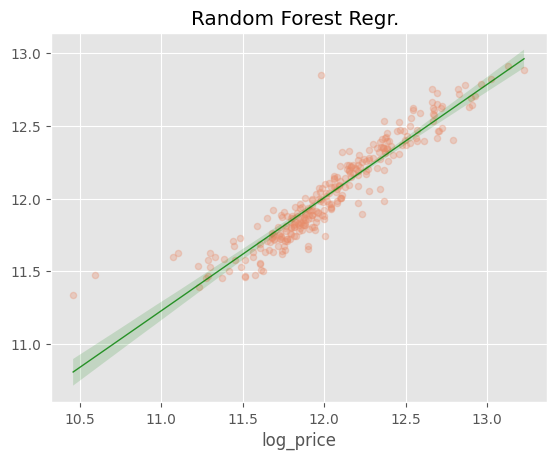

In [43]:
sns.regplot(x=y_val, y=y_pred, scatter_kws={'s': 20, 'alpha': 0.3}, line_kws={'color': 'green', 'lw': 1, 'alpha': 0.8})
plt.title(f"Random Forest Regr. ")
plt.show()

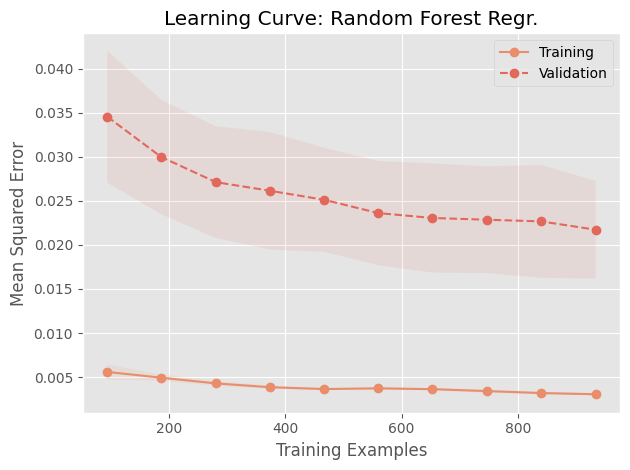

In [46]:
from utils import plot_learning_curve

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=1)

val_rfr = RandomForestRegressor(**study.best_params, n_jobs=-1, random_state=2)

plot_learning_curve(val_rfr, X_train, y_train, title="Learning Curve: Random Forest Regr.")
plt.show()

In [47]:
metrics = {
    'model': 'RFR',
    'params': f'{study.best_params}',
    'RMSE': round(rmse, 4),
    'R2': round(r2, 4)
}

metrics = pd.DataFrame(metrics, index=[0])

metrics.to_csv(os.path.join(METRICS_PATH, '0200_metrics.csv'))